In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import mpld3

import subprocess
import socket
import time
import os
import gc
import datetime
import logging

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

from common_simulator import *

In [2]:
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]

# Run only one of these three:

In [3]:
ic = 'dambreak'
# ref_file = lambda simulator: os.path.join('reference', 'SWASHES_4096_1.npz')
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
ref_file = lambda simulator: gen_filename(None, nx=domain_sizes[-1][0], 
                                                ny=max(domain_sizes[-1][1], GetSimulator.num_ghost_cells[simulator.__name__]), 
                                                prefix="space", ic=ic, simulator=simulator.__name__) 

In [4]:
ic = 'constant'
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
ref_file = lambda simulator: gen_filename(None, nx=domain_sizes[-1][0], 
                                                ny=max(domain_sizes[-1][1], GetSimulator.num_ghost_cells[simulator.__name__]), 
                                                prefix="space", ic=ic, simulator=simulator.__name__) 

In [5]:
ic = 'bump'
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
domain_sizes = np.loadtxt('domain_sizes.csv').transpose().astype(int)
ref_file_size = domain_sizes[-1]
domain_sizes = domain_sizes[:-1]
ref_file = lambda simulator: gen_filename(None, nx=ref_file_size[0], ny=ref_file_size[1], prefix="space", ic=ic, simulator=simulator.__name__)

# Then run everything below this

In [6]:
print(f'ic = {ic}')

ic = bump


# Run the simulators

In [7]:
# subprocess.run(['bash', 'generate_data.sh'])
# Run this by hand 

# Space calculations

In [8]:
for simulator in simulators:
    commands = 'python calculator_simulator.py'.split(' ')
    commands += ['space']
    commands += [ic]
    commands += [simulator.__name__]
    commands += ['--ref', f'{ref_file(simulator)}']
    commands += ['--sizes']
    commands += [f'{nx}_{ny}' for nx,ny in domain_sizes]
    subprocess.run(commands).check_returncode()


Created space_data/results/bump/LxF.npz
Created space_data/results/bump/FORCE.npz
Created space_data/results/bump/HLL.npz
Created space_data/results/bump/HLL2.npz
Created space_data/results/bump/KP07.npz
Created space_data/results/bump/KP07_dimsplit.npz
Created space_data/results/bump/WAF.npz


# Time calculations

In [9]:
for simulator in simulators:
    commands = 'python calculator_simulator.py'.split(' ')
    commands += ['time']
    commands += [ic]
    commands += [simulator.__name__]
    commands += ['--sizes']
    commands += [f'{nx}_{ny}' for nx,ny in domain_sizes]
    subprocess.run(commands, check=True)

Created time_data/results/bump/LxF.npz
Created time_data/results/bump/FORCE.npz
Created time_data/results/bump/HLL.npz
Created time_data/results/bump/HLL2.npz
Created time_data/results/bump/KP07.npz
Created time_data/results/bump/KP07_dimsplit.npz
Created time_data/results/bump/WAF.npz


## Load data

In [10]:
time_ds_x, time_ds_y = [], []
space_ds_x, space_ds_y = [], []
megacells_per_sec = []
peak_megacells_per_sec = np.zeros(len(simulators))
sim_errors = []
sim_cons = []
sim_nt = []
longsim_nt = []
sim_tf = []
longsim_tf = []
longsim_elapsed_time = []

for  i, simulator in enumerate(simulators):
    # time data
    filename = gen_results_filename('time', simulator.__name__, ic)
    with np.load(filename) as d:
        order = np.argsort(d['ds_x'])
        time_ds_x.append(d['ds_x'][order])
        time_ds_y.append(d['ds_y'][order])
        megacells_per_sec.append(d['megacells_per_sec'][order])
        peak_megacells_per_sec[i] = d['peak_megacells_per_sec']
        longsim_nt.append(d['sim_nt'])
        longsim_tf.append(d['sim_tf'][order])
        longsim_elapsed_time.append(d['longsim_elapsed_time'][order])

    # space data
    filename = gen_results_filename('space', simulator.__name__, ic)
    with np.load(filename) as d:
        order = np.argsort(d['ds_x'])
        space_ds_x.append(d['ds_x'][order])
        space_ds_y.append(d['ds_y'][order])
        sim_errors.append(d['sim_errors'][order])
        sim_cons.append(d['sim_cons'][order])
        sim_nt.append(d['sim_nt'][order])
        sim_tf.append(d['sim_tf'])

# Reduce orders for redundant data
time_ds_x = np.array(time_ds_x)
time_ds_y = np.array(time_ds_y)
space_ds_x = np.array(space_ds_x)
space_ds_y = np.array(space_ds_y)
assert np.all(time_ds_x == space_ds_x) 
assert np.all(time_ds_y == space_ds_y) 

assert np.all(time_ds_x == time_ds_x[0]) 
#assert np.all(time_ds_y == time_ds_y[0]) 
ds_x = time_ds_x#[0]
ds_y = time_ds_y#[0]

assert np.all(longsim_nt == longsim_nt[0])
assert np.all(sim_tf == sim_tf[0])
longsim_nt = longsim_nt[0]
sim_tf = sim_tf[0]

megacells_per_sec = np.array(megacells_per_sec)
sim_errors = np.array(sim_errors)
sim_cons = np.array(sim_cons)
sim_nt = np.array(sim_nt)
longsim_tf = np.array(longsim_tf)

gc.collect()

649

Text(0.5, 1.0, 'Megacells per second')

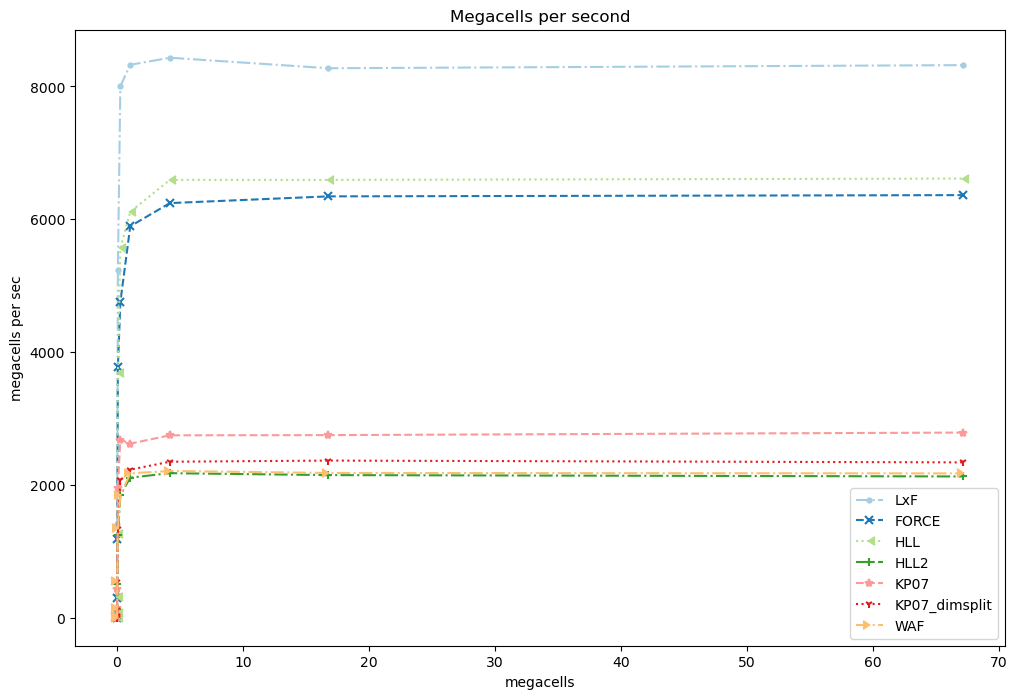

In [11]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.plot(ds_x[i] * ds_y[i] * 10**-6, megacells_per_sec[i], label = simulator.__name__)
    plt.xlabel("megacells")
    plt.ylabel("megacells per sec")
plt.legend()
plt.title("Megacells per second")
# miscPlotting.save_figure(fig, "megacells per second", ic)

0 <class 'GPUSimulators.LxF.LxF'> 8342.584953292782
1 <class 'GPUSimulators.FORCE.FORCE'> 6317.7941296090285
2 <class 'GPUSimulators.HLL.HLL'> 6599.9949088199755
3 <class 'GPUSimulators.HLL2.HLL2'> 2151.8657361093797
4 <class 'GPUSimulators.KP07.KP07'> 2762.7344581087436
5 <class 'GPUSimulators.KP07_dimsplit.KP07_dimsplit'> 2352.7478319274564
6 <class 'GPUSimulators.WAF.WAF'> 2188.97233668823


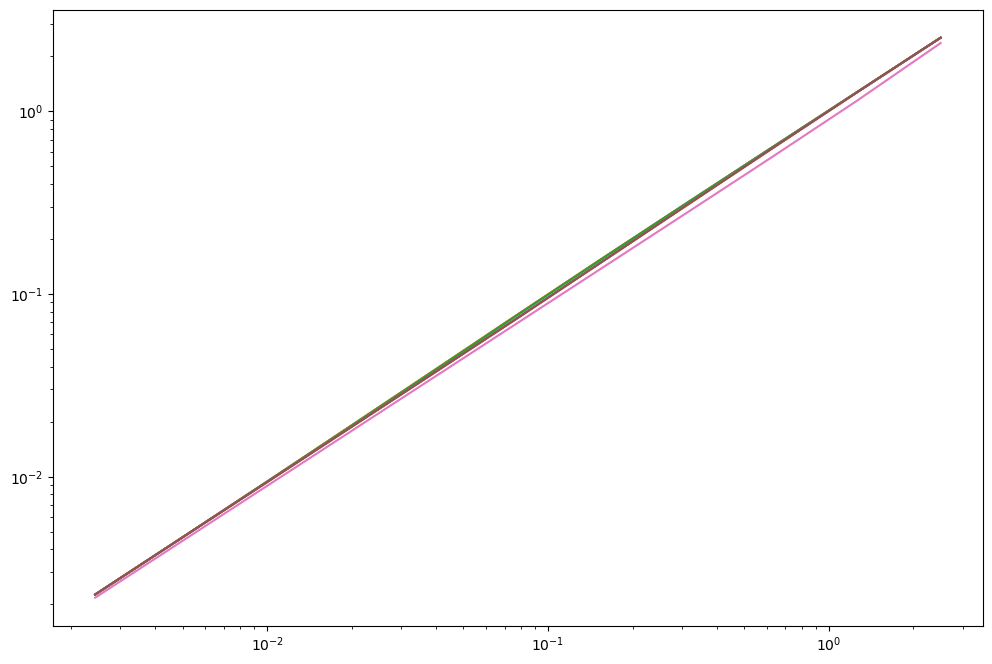

In [13]:
import scipy
longsim_average_dt = longsim_tf / longsim_nt
sim_average_dt = sim_tf / sim_nt
for i, simulator in enumerate(simulators):
    print(i, simulator, peak_megacells_per_sec[i])
    plt.loglog(20/ds_x[i], longsim_average_dt[i])

Text(0, 0.5, 'seconds / megacell')

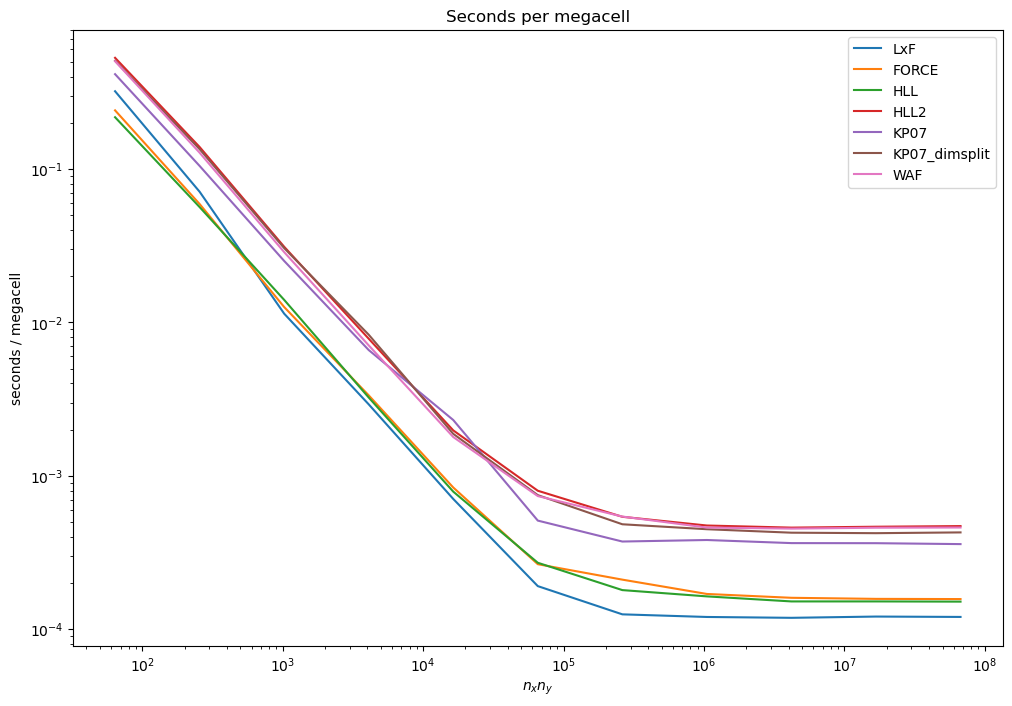

In [14]:
secs_per_timestep_megacell = longsim_elapsed_time / (longsim_nt * ds_x * ds_y * 10**-6)
for i, sim in enumerate(simulators):
    plt.loglog(ds_x[i] * ds_y[i], 1.0/(megacells_per_sec[i]), label=sim.__name__)
plt.legend()
plt.title("Seconds per megacell")
plt.xlabel("$n_x n_y$")
plt.ylabel("seconds / megacell")

Text(0.5, 1.0, 'Peak seconds per megacell')

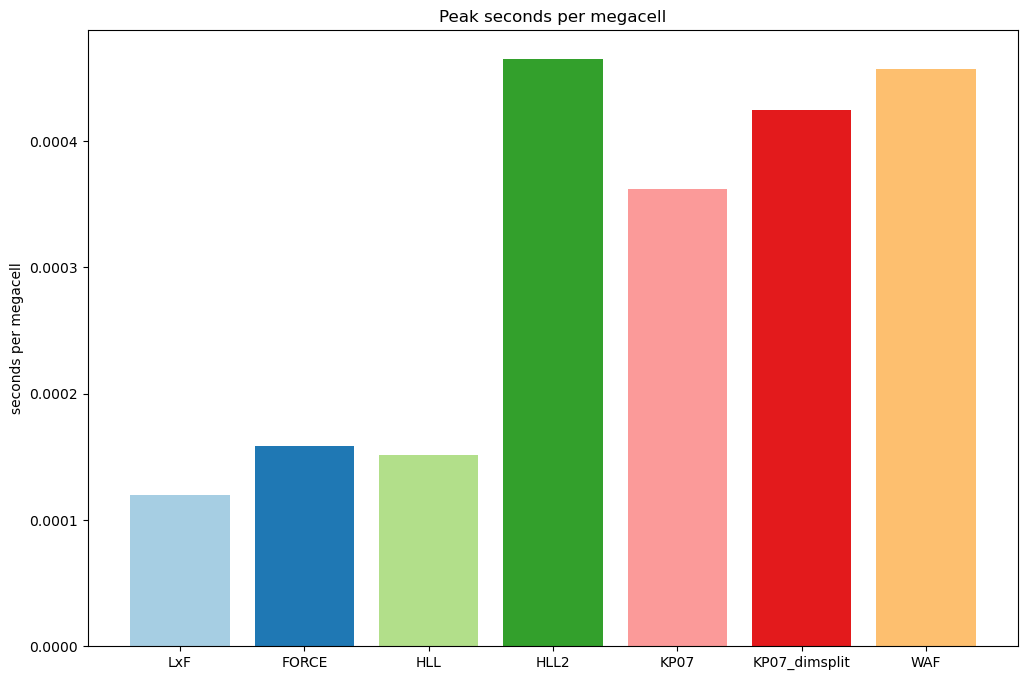

In [15]:
import seaborn as sns
plt.bar([sim.__name__ for sim in simulators], 1.0/peak_megacells_per_sec, color=sns.color_palette("Paired", 7))
plt.ylabel("seconds per megacell")
plt.title("Peak seconds per megacell")

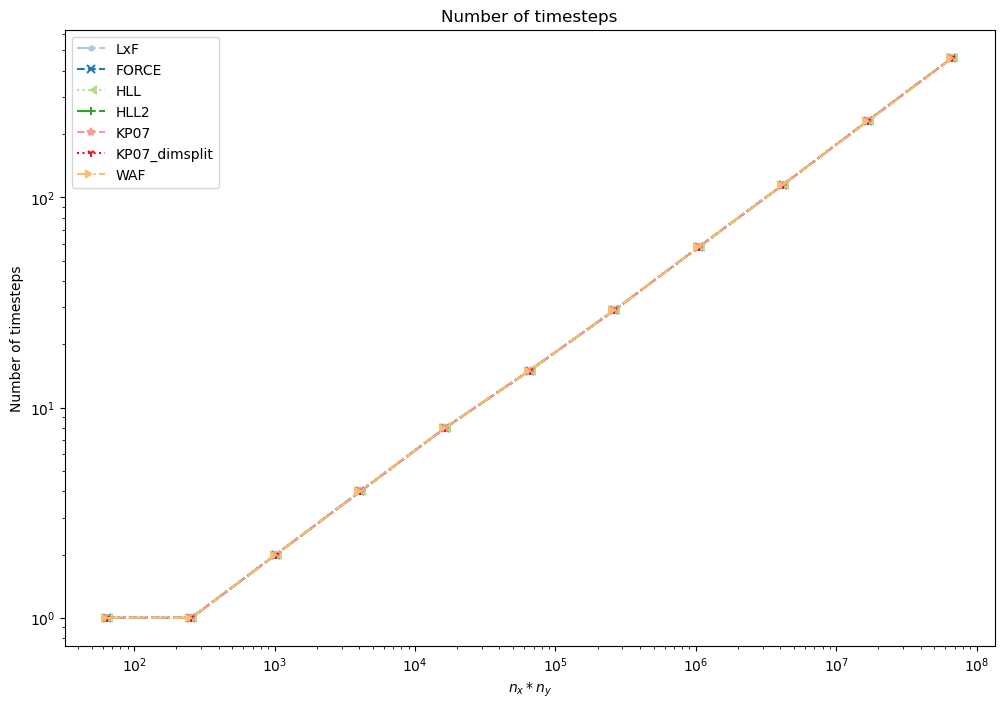

In [16]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.loglog(ds_x[i] * ds_y[i], sim_nt[i], label = simulator.__name__)
    plt.xlabel("$n_x * n_y$")
    plt.ylabel("Number of timesteps")
plt.legend()
plt.title("Number of timesteps")
miscPlotting.save_figure(fig, "number_of_timesteps", ic)

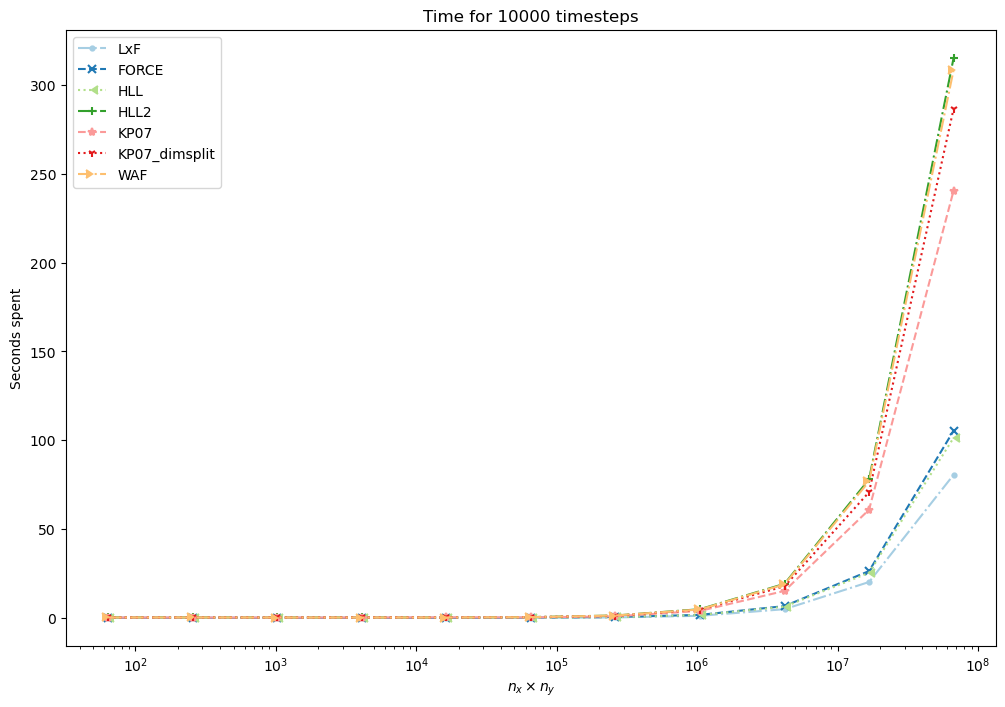

In [17]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.semilogx(ds_x[i] * ds_y[i], longsim_elapsed_time[i], label = f"{simulator.__name__}")
    plt.xlabel("$n_x\\times n_y$")
    plt.ylabel("Seconds spent")
plt.legend()
plt.title(f"Time for {longsim_nt.astype(int)} timesteps")
miscPlotting.save_figure(fig, "time_spent_for_bignumber_timesteps", ic)

## #TODO CONVERGENCE PLOTS X-AXIS CHECK

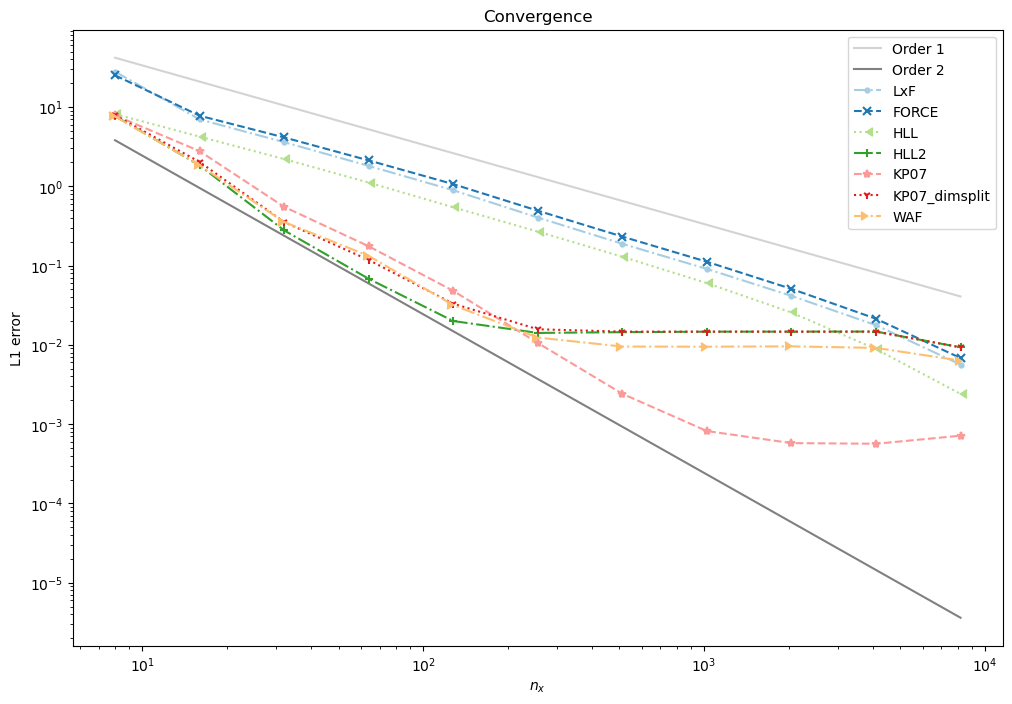

In [18]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()
x_axis_start = np.min(ds_x)
scaling = np.max(sim_errors[:,0]) * 1.5 * x_axis_start
plt.plot(ds_x[0], scaling / np.array(ds_x[0]), '-', c='lightgray', label='Order 1')
scaling = np.min(sim_errors[:,0]) * 0.5 * x_axis_start ** 2
plt.plot(ds_x[0], scaling / np.power(ds_x[0], 2), '-', c='gray', label='Order 2')

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.loglog(ds_x[i,:], sim_errors[i,:], label = simulator.__name__)
    plt.xlabel("$n_x$")
    plt.ylabel("L1 error")
plt.legend()
plt.title("Convergence")
miscPlotting.save_figure(fig, "convergence_rate", ic)

## Time vs absolute error plot

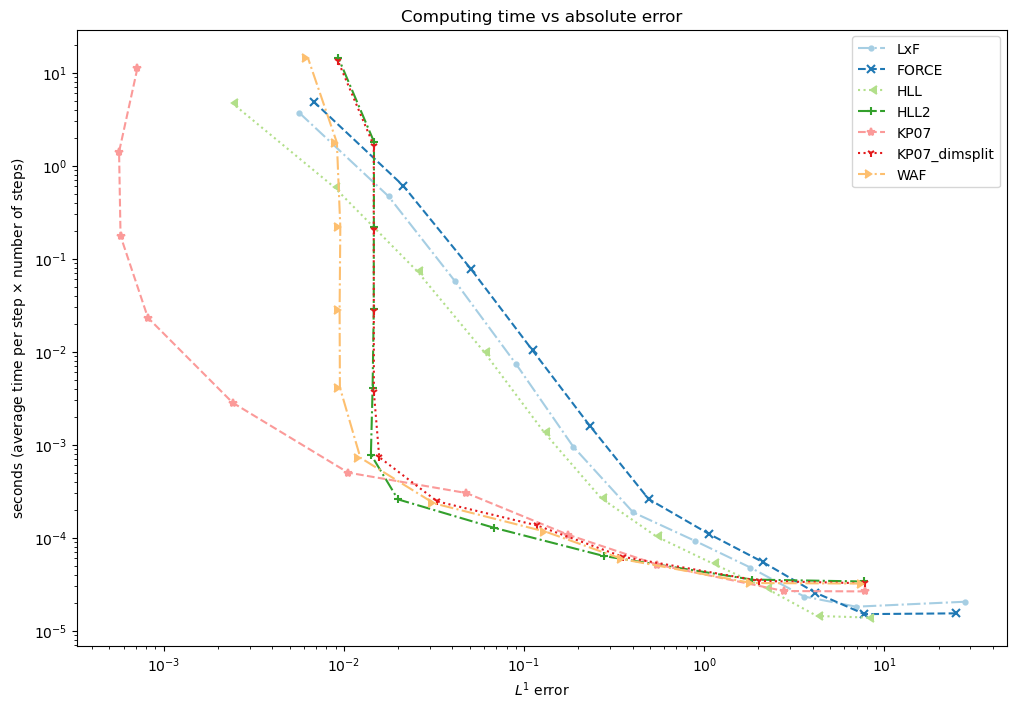

In [20]:
# Plot the timing and error data
import miscPlotting
import importlib
importlib.reload(miscPlotting)
secs_per_timestep = longsim_elapsed_time / longsim_nt
fig = plt.figure()
miscPlotting.setBwStyles(fig.gca())
plt.title("Computing time vs absolute error")

for i, simulator in enumerate(simulators):
    plt.loglog(sim_errors[i,:], secs_per_timestep[i,:] * sim_nt[i,:], label = simulator.__name__)
    plt.xlabel("$L^1$ error")
    plt.ylabel("seconds (average time per step $\\times$ number of steps)")

plt.legend()
miscPlotting.save_figure(fig, "time_to_solution", ic)

## Peak performance vs rate of convergence

,8.0,16.0,32.0,64.0,128.0,256.0,512.0,1024.0,2048.0,4096.0
LxF,1.998258,0.954354,0.994299,1.020102,1.141930,1.102197,1.051417,1.129680,1.225940,1.649267
FORCE,1.694277,0.908390,0.963107,0.993575,1.112790,1.084293,1.054556,1.135749,1.251844,1.645686
HLL,0.944307,0.939418,0.985642,1.034354,1.018933,1.054077,1.103605,1.230922,1.532758,1.875637
HLL2,2.063667,2.722687,2.027756,1.769602,0.498192,-0.031640,-0.020922,-0.001875,-0.002993,0.659901
KP07,1.499801,2.333361,1.649717,1.868909,2.181097,2.129757,1.561064,0.504704,0.027053,-0.337180
KP07_dimsplit,1.954129,2.516471,1.588942,1.831754,1.070026,0.098896,0.001522,0.001496,-0.001642,0.657203
WAF,2.049553,2.375049,1.418668,2.063500,1.357387,0.377479,0.005441,-0.012978,0.063315,0.530113


,Max,Min,Mean
LxF,1.998258,0.954354,1.226744
FORCE,1.694277,0.908390,1.184427
HLL,1.875637,0.939418,1.171965
HLL2,2.722687,-0.031640,0.968437
KP07,2.333361,-0.337180,1.341828
KP07_dimsplit,2.516471,-0.001642,0.971880
WAF,2.375049,-0.012978,1.022753


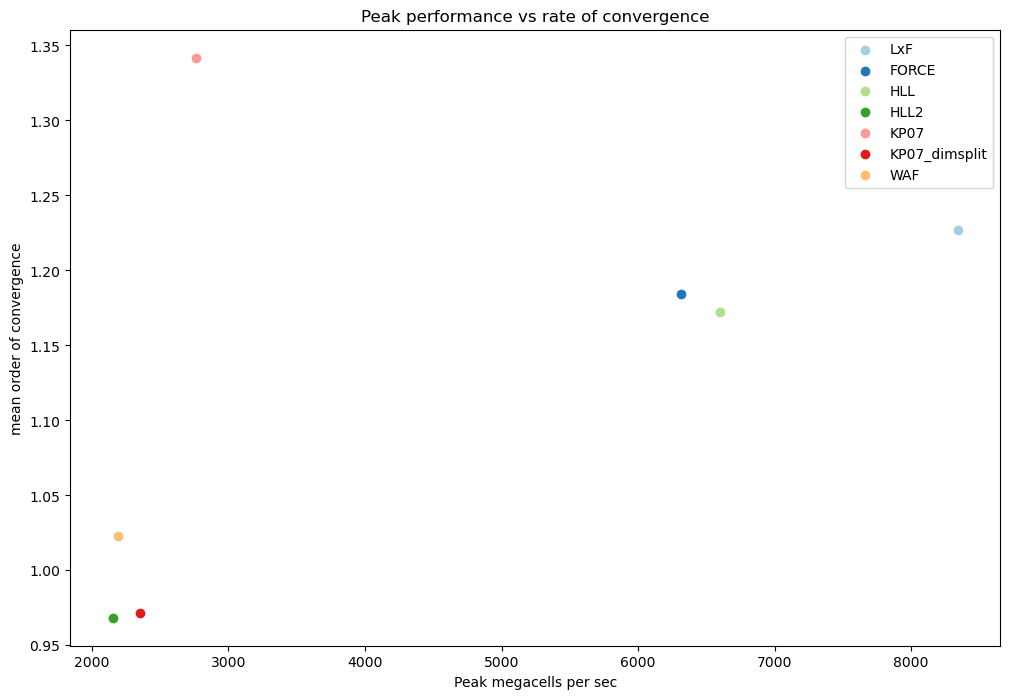

In [21]:
order = np.zeros((ds_x.shape[0], ds_x.shape[1]-1))
for i, sim in enumerate(simulators):
    order[i, :] = np.log2(sim_errors[i,:-1]/sim_errors[i,1:])

import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()
miscPlotting.setBwStyles(fig.gca())
plt.title("Peak performance vs rate of convergence")
for i, sim in enumerate(simulators):
    plt.scatter(peak_megacells_per_sec[i], np.mean(order[i]), color=sns.color_palette("Paired", 7)[i], label=sim.__name__)
plt.xlabel("Peak megacells per sec")
plt.ylabel("mean order of convergence")
plt.legend()

import pandas as pd
from IPython.display import display
table = pd.DataFrame(order, columns=ds_x[0,:-1], index=[simulator.__name__ for simulator in simulators])
display(table)

order_summary = pd.DataFrame(np.empty((len(simulators), 3)), columns=['Max', 'Min', 'Mean'], index=[simulator.__name__ for simulator in simulators])
for i, simulator in enumerate(simulators):
    order_summary.loc[simulator.__name__] = [np.max(order[i,:]), 
        np.min(order[i,:]), 
        np.mean(order[i,:])]
display(order_summary)

# miscPlotting.save_figure(fig, "time_to_solution", ic)

## Solution plots

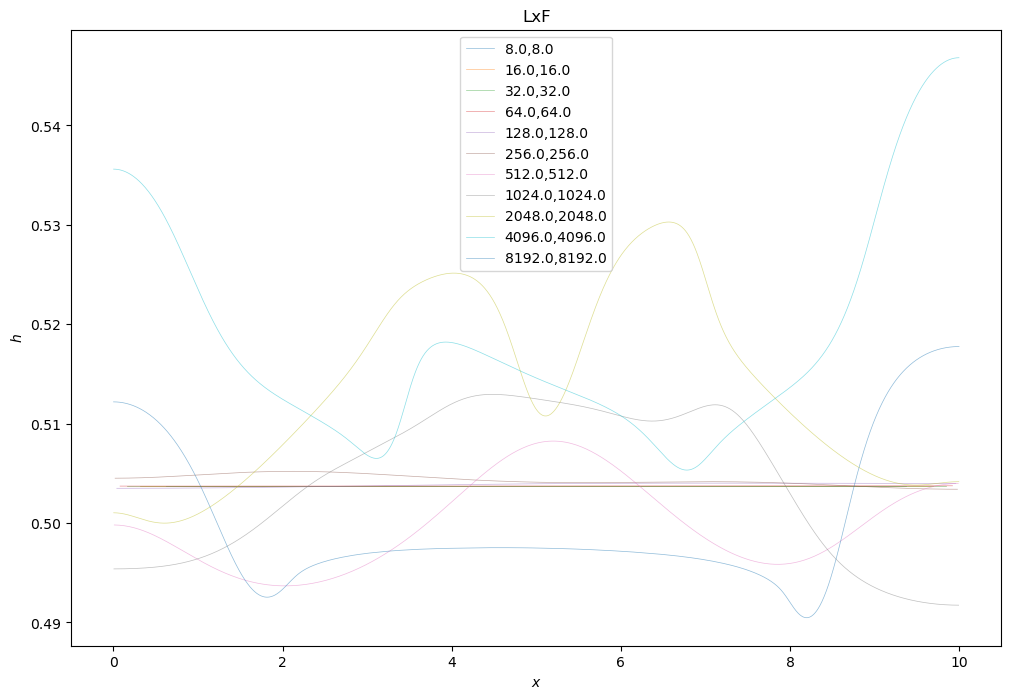

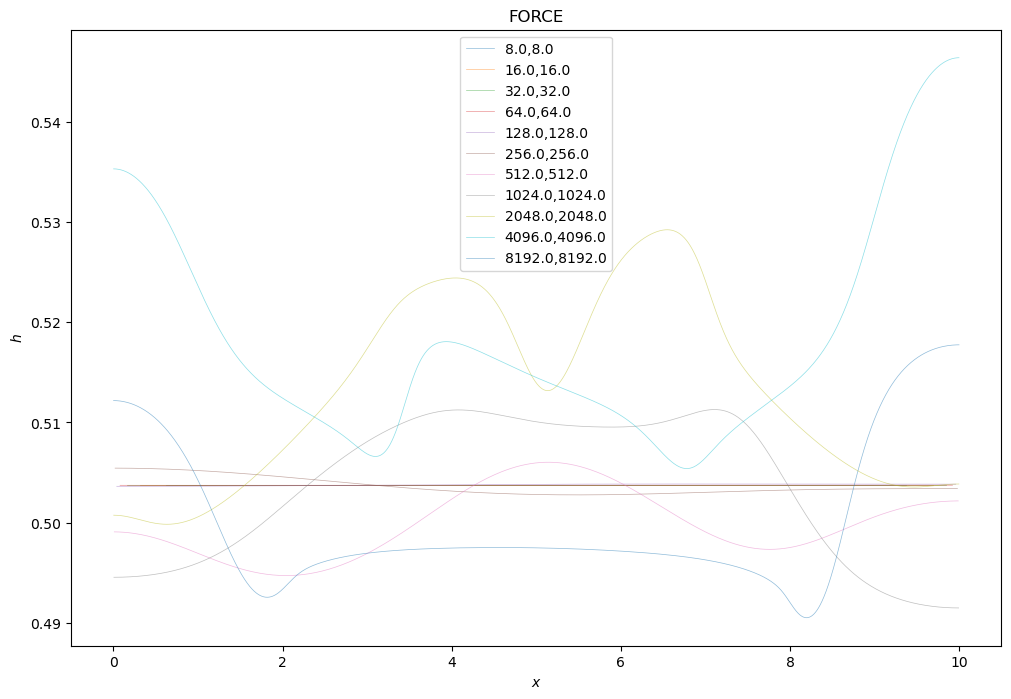

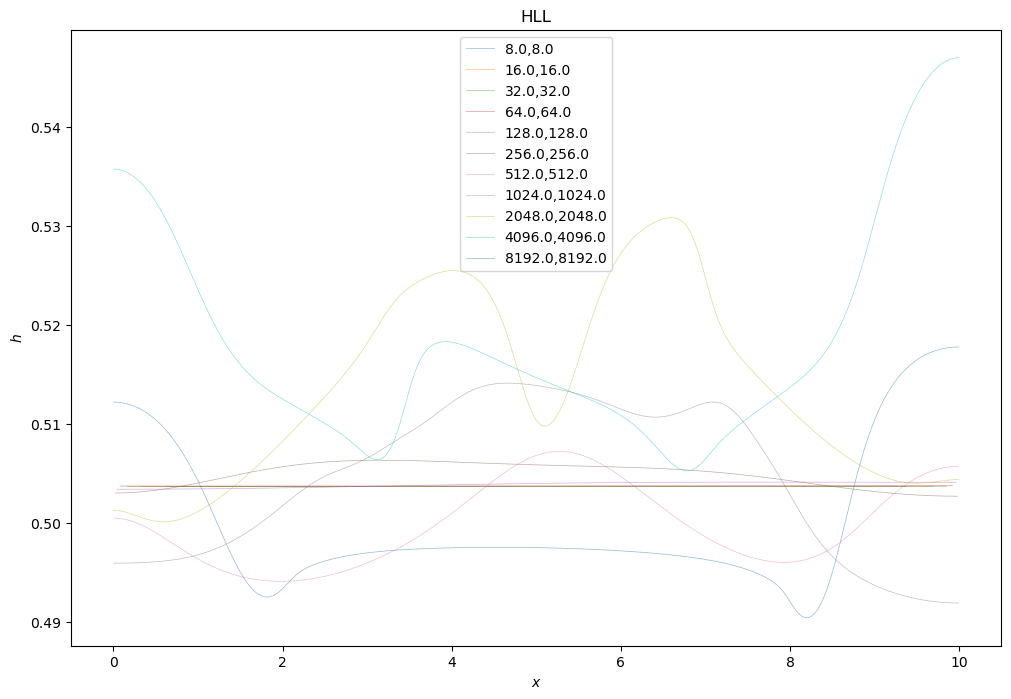

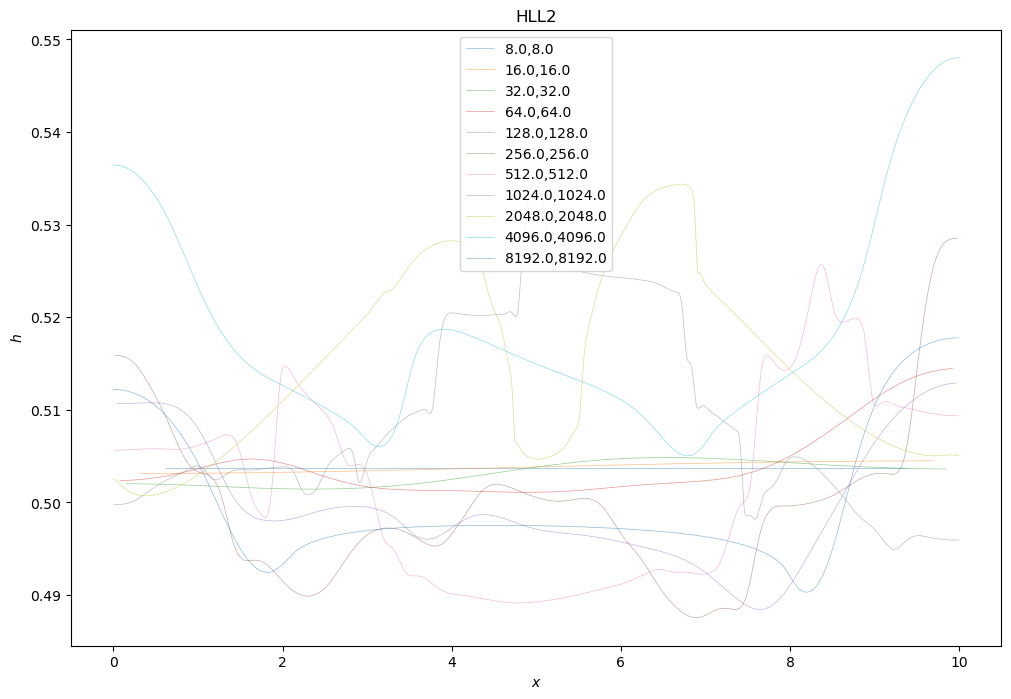

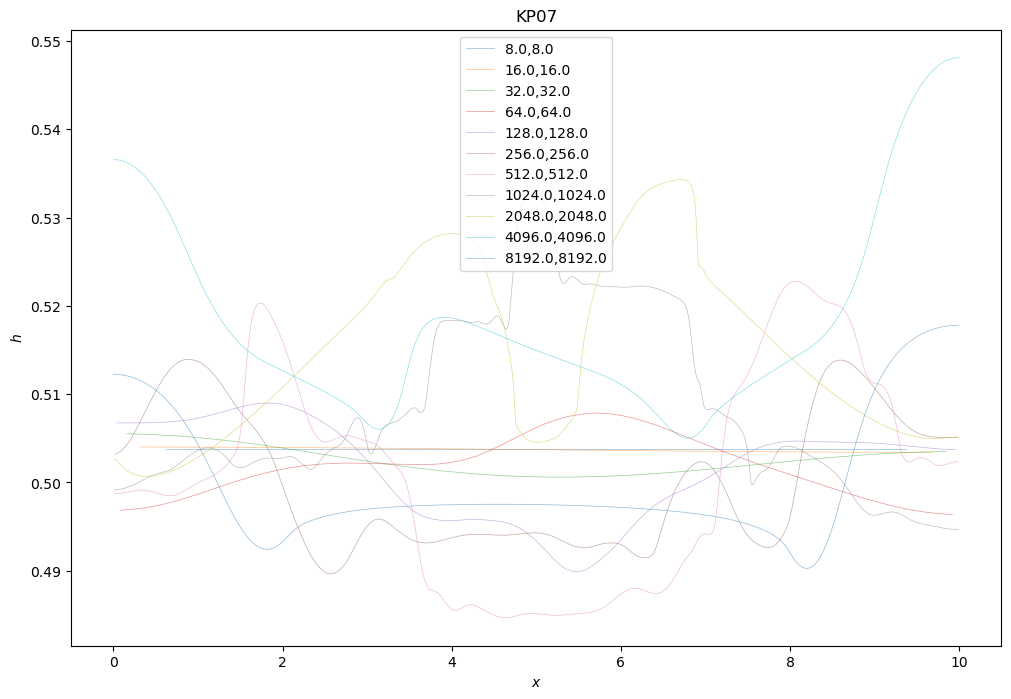

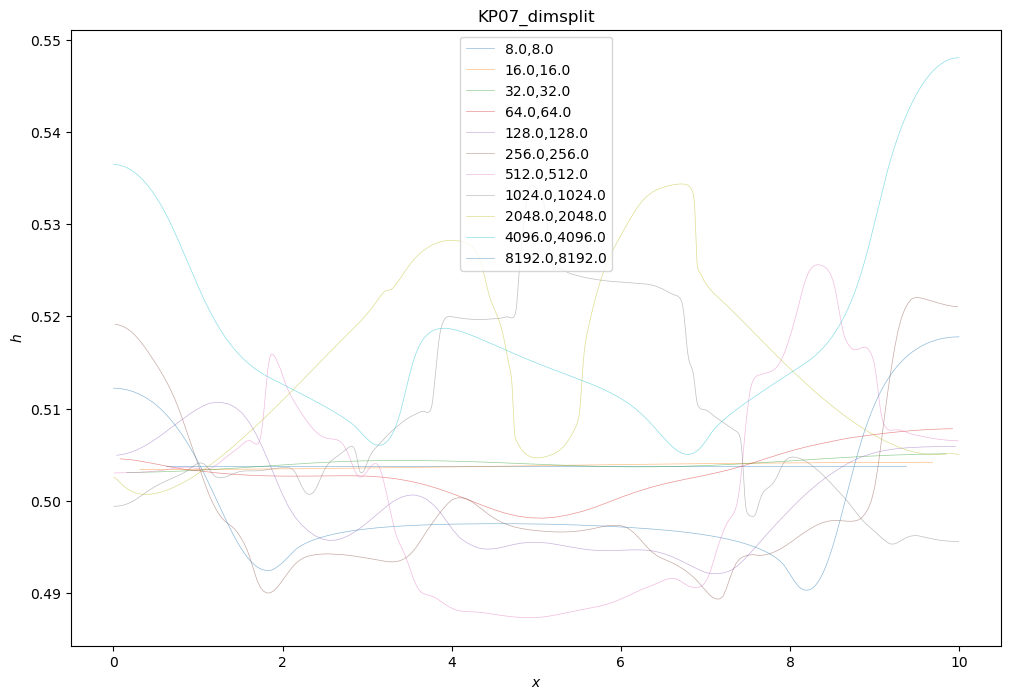

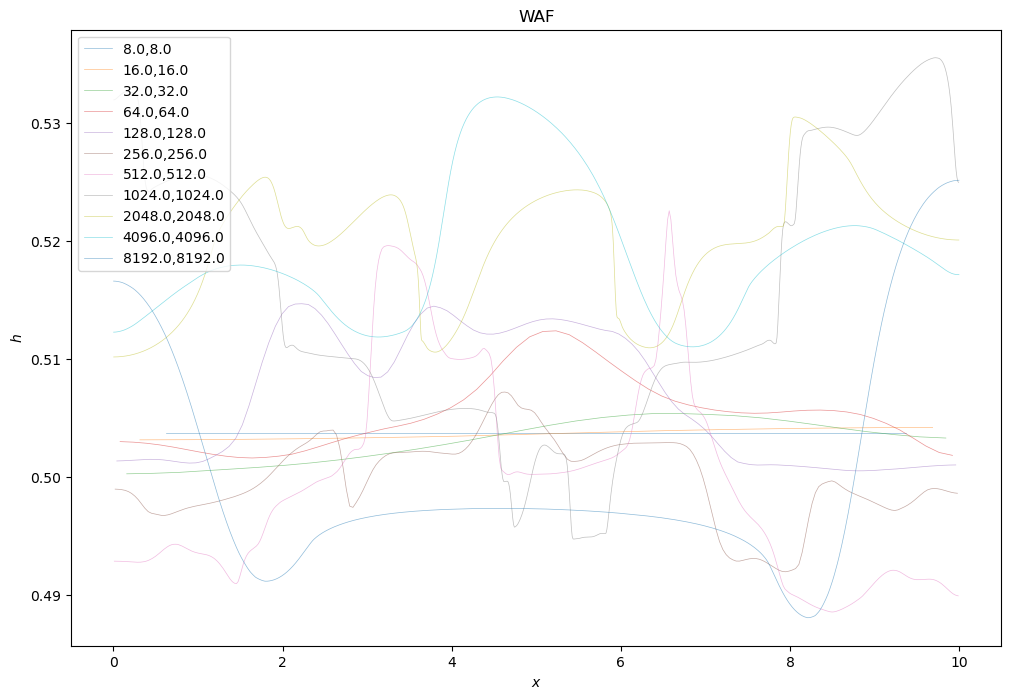

In [22]:
def plot_solution(simulator, nx, ny, label, **kwargs):
    datafilename = gen_filename(None, nx, ny, ic=ic, simulator=simulator.__name__, prefix='time')
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        
    x = np.linspace(0.5, nx-0.5, nx)*10.0/float(nx)
    y = h[int(h.shape[0]/2),:]
    
    plt.plot(x, y, label=label, **kwargs)
    
    h = None
    x = None
    gc.collect() # Force 

for i, simulator in enumerate(simulators):
    fig = plt.figure()
    # miscPlotting.setBwStyles(fig.gca())
#    plot_solution(simulator, ref_nx, label=str(ref_nx) +" (ref)", c='k', ls='dotted', marker=None, lw=1, alpha=0.5)
    for nx,ny in zip(ds_x[i], ds_y[i]):
#        fig.set_prop_cycle(cycler('color', miscPlotting.sns.color_palette()))
        plot_solution(simulator, nx.astype(int), ny.astype(int), label=str(nx) + ',' + str(ny), marker=None, lw=0.5, alpha=0.5)
    plt.xlabel("$x$")
    plt.ylabel("$h$")
    plt.legend()
    plt.title(simulator.__name__)
    miscPlotting.save_figure(fig, f"solutions_{simulator.__name__}", ic)